# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model


from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

Using TensorFlow backend.


In [4]:
from livelossplot.keras import PlotLossesCallback
from tqdm import tqdm_notebook

In [5]:
# custom layers from external files
from layers.embeddings import ElmoLayer
from models.build_models import build_model_elmo, build_model_elmo_kapelner, initialize_vars
from models.train_models import train_elmomod_cv
from utils.utils import *

In [6]:
# custom layers from external files
from layers.embeddings import BertLayer
from models.build_models import *
from models.train_models import *
from utils.utils import *

In [7]:
# # spacy for tokenizer
# import spacy
# from spacy.tokenizer import Tokenizer
# # from spacy.lang.en import English

In [8]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# import dataset 

## DSCoVAR sentences

In [9]:
# DSCoVAR - BWS
sent_dsc_bert = np.load("dscovar_sentences_bert.pickle", allow_pickle=True)
sent_dsc_elmo_notarg = np.load("dscovar_sentences_notarg_elmo_max160.pickle", allow_pickle=True)
score_dsc_bws = np.load("resp_bws.pickle", allow_pickle=True)

In [10]:
len(sent_dsc_bert[0])

1783

In [11]:
len(sent_dsc_elmo_notarg[0])

1783

In [12]:
len(score_dsc_bws)

1783

## DSCoVAR sentences - in a multi-sentenced form for BERT??

In [13]:
sent_dsc_bert = np.load("dscovar_sentences_notarg_bert_nocut_mult.npy.npz", allow_pickle=True)
#          input_ids = bert_input_nocut[0], 
#          input_masks = bert_input_nocut[1], 
#          segment_ids = bert_input_nocut[2], 
#          targ_locs = bert_input_nocut[3], 
#          lex_features = bert_input_nocut[4], 
#          scores = bert_input_nocut[5])

In [14]:
input_ids_dsc_bert = sent_dsc_bert['input_ids']
input_masks_dsc_bert = sent_dsc_bert['input_masks']
segment_ids_dsc_bert = sent_dsc_bert['segment_ids']
targets_dsc_bert = sent_dsc_bert['targets']
targ_locs_dsc_bert = sent_dsc_bert['targ_locs']
# lex_features_kap_bert = sent_dsc_bert['lex_features']
scores_dsc_bert = sent_dsc_bert['scores']

## Kapelner et al. sentences

In [15]:
sent_kap_elmo = np.load("kapelner_sentences_notarg_elmo_nocut.npy.npz", allow_pickle=True)
#          sent_len=sentences_notarg[0], 
#          sentences_notarg=sentences_notarg[1:4], 
#          sentences_lex=sentences_notarg[4], 
#          sentences_score=sentences_score, 
#          targets=targets)

In [16]:
sent_kap_elmo_len=sent_kap_elmo['sent_len']
sentences_kap_elmo_notarg=sent_kap_elmo['sentences_notarg']
sentences_kap_elmo_lex=sent_kap_elmo['sentences_lex']
sentences_kap_elmo_score=sent_kap_elmo['sentences_score']
targets_kap_elmo=sent_kap_elmo['targets']

In [17]:
sent_kap_bert = np.load("kapelner_sentences_notarg_bert_nocut.npy.npz", allow_pickle=True)
#          input_ids = bert_input_nocut[0], 
#          input_masks = bert_input_nocut[1], 
#          segment_ids = bert_input_nocut[2], 
#          targ_locs = bert_input_nocut[3], 
#          lex_features = bert_input_nocut[4], 
#          scores = bert_input_nocut[5])

In [18]:
input_ids_kap_bert = sent_kap_bert['input_ids']
input_masks_kap_bert = sent_kap_bert['input_masks']
segment_ids_kap_bert = sent_kap_bert['segment_ids']
targets_kap_bert = sent_kap_bert['targets']
targ_locs_kap_bert = sent_kap_bert['targ_locs']
lex_features_kap_bert = sent_kap_bert['lex_features']
scores_kap_bert = sent_kap_bert['scores']

# Predictions 1: Kapelner -> dscovar

## ELMo + Att 

In [20]:
MAX_SEQ_LEN_ELMO = 160
_batch_size_elmo = 16
_lr_elmo = 1e-3

### finetune

In [47]:
K.clear_session()
sess = tf.Session()

model_kap_elmo = build_model_elmo(MAX_SEQ_LEN_ELMO, 
                                  finetune_emb=True, attention_layer=True, 
                                  sep_cntx_targ=False, lr=_lr_elmo)

initialize_vars(sess)

In [48]:
model_kap_elmo.load_weights("model_weights_kapelner/elmo/1emb/model_elmo_notarg_wtattn_nocut_cv_full.tf")

In [49]:
pred_elmo__dsc_kap = np.reshape(model_kap_elmo.predict(sent_dsc_elmo_notarg), -1)

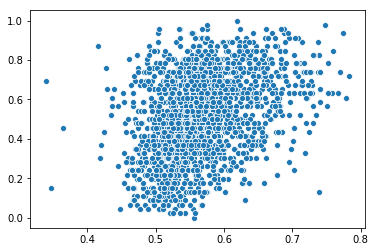

In [50]:
sns.scatterplot(pred_elmo__dsc_kap, score_dsc_bws)

In [51]:
r2_score(score_dsc_bws, pred_elmo__dsc_kap)

0.069415292805031

In [52]:
spearmanr(score_dsc_bws, pred_elmo__dsc_kap)

SpearmanrResult(correlation=0.3489188006932779, pvalue=3.3616320051525325e-52)

In [53]:
(round(rmse(score_dsc_bws, pred_elmo__dsc_kap), 3),
 round(1-rocauc(score_dsc_bws, pred_elmo__dsc_kap, .20, "low"), 3),
 round(rocauc(score_dsc_bws, pred_elmo__dsc_kap, .50, "high"), 3),
 round(rocauc(score_dsc_bws, pred_elmo__dsc_kap, .80, "high"), 3),)

(0.206, 0.711, 0.678, 0.651)

### no-tune

In [21]:
K.clear_session()
sess = tf.Session()

model_kap_elmo = build_model_elmo(MAX_SEQ_LEN_ELMO, 
                                  finetune_emb=False, attention_layer=True, 
                                  sep_cntx_targ=False, lr=_lr_elmo)

initialize_vars(sess)

In [22]:
model_kap_elmo.load_weights("model_weights_kapelner/elmo/1emb/model_elmo_notune_notarg_wtattn_nocut_cv_full.tf")

In [23]:
pred_elmo__dsc_kap = np.reshape(model_kap_elmo.predict(sent_dsc_elmo_notarg), -1)

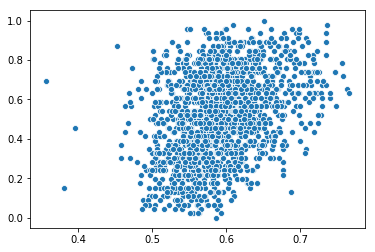

In [24]:
sns.scatterplot(pred_elmo__dsc_kap, score_dsc_bws)

In [25]:
r2_score(score_dsc_bws, pred_elmo__dsc_kap)

0.010454515989260948

In [26]:
spearmanr(score_dsc_bws, pred_elmo__dsc_kap)

SpearmanrResult(correlation=0.3682252034559012, pvalue=2.2800791803563694e-58)

In [27]:
(round(rmse(score_dsc_bws, pred_elmo__dsc_kap), 3),
 round(1-rocauc(score_dsc_bws, pred_elmo__dsc_kap, .20, "low"), 3),
 round(rocauc(score_dsc_bws, pred_elmo__dsc_kap, .50, "high"), 3),
 round(rocauc(score_dsc_bws, pred_elmo__dsc_kap, .80, "high"), 3),)

(0.212, 0.724, 0.685, 0.656)

## BERT + Att 

In [19]:
MAX_SEQ_LEN_BERT = 258
_batch_size_bert = 16
_lr_bert = 3e-5

In [20]:
K.clear_session()
# sess = tf.Session(config=tf.ConfigProto(
#         device_count = {'CPU': 0}
#     ))
sess = tf.Session()

model_kap_bert = build_model_bert(MAX_SEQ_LEN_BERT, 
                                  finetune_emb=True, attention_layer=True, 
                                  sep_cntx_targ=False, lr=_lr_bert)

initialize_vars(sess)

In [22]:
model_kap_bert.set_weights(np.load("model_weights_kapelner/bert/1emb/model_bert_notarg_wtattn_nocut_full____2.npy", allow_pickle=True))

In [25]:
pred_bert__dsc_kap = model_kap_bert.predict([input_ids_dsc_bert,  input_masks_dsc_bert, 
                                             segment_ids_dsc_bert, targ_locs_dsc_bert])
pred_bert__dsc_kap = np.reshape(pred_bert__dsc_kap, -1)

In [26]:
r2_score(score_dsc_bws, pred_bert__dsc_kap)

0.12761875300031933

In [27]:
spearmanr(score_dsc_bws, pred_bert__dsc_kap)

SpearmanrResult(correlation=0.49868113012711857, pvalue=9.968553447580964e-113)

In [28]:
(round(rmse(score_dsc_bws, pred_bert__dsc_kap), 3),
 round(1-rocauc(score_dsc_bws, pred_bert__dsc_kap, .20, "low"), 3),
 round(rocauc(score_dsc_bws, pred_bert__dsc_kap, .50, "high"), 3),
 round(rocauc(score_dsc_bws, pred_bert__dsc_kap, .80, "high"), 3))

(0.199, 0.784, 0.752, 0.715)

In [36]:
# _tokenizer = create_tokenizer_from_hub_module()
# _examples_dsc  = convert_text_to_examples(sent_dsc_bert[0],  sent_dsc_bert[1],  score_dsc_bws)
# _input_ids_dsc,  _input_masks_dsc, _segment_ids_dsc, _targ_locs_dsc,  _scores_dsc  = convert_examples_to_features(_tokenizer, _examples_dsc, False, MAX_SEQ_LEN_BERT)

In [58]:
# # workaround from https://github.com/tensorflow/tensorflow/issues/14356#issuecomment-385962623
# def load_model():
#     global model_kap_bert
    
#     K.clear_session()
#     sess = tf.Session()

#     model_kap_bert = build_model_bert(MAX_SEQ_LEN_BERT, 
#                                       finetune_emb=True, attention_layer=True, 
#                                       sep_cntx_targ=False, lr=_lr_bert)
# #     initialize_vars(sess)    
# #     model_kap_bert.load_weights("model_weights_kapelner/bert/1emb/model_bert_notarg_wtattn_nocut_full222.tf")
# #     model_kap_bert.load_weights("model_weights_kapelner/bert/1emb/model_bert_notune_notarg_wtattn_nocut_full.tf")
#     initialize_vars(sess)   # !!!BUG!!!: ignores the learned weights (load_weights); reinitializing the graph
#     global graph
#     graph = tf.get_default_graph()


# load_model()
# with graph.as_default():
# #     pred_bert__dsc_kap = model_kap_bert.predict([_input_ids_dsc,  _input_masks_dsc, 
# #                                                  _segment_ids_dsc, _targ_locs_dsc])
#     pred_bert__dsc_kap = model_kap_bert.predict([input_ids_dsc_bert,  input_masks_dsc_bert, 
#                                                  segment_ids_dsc_bert, targ_locs_dsc_bert])
#     pred_bert__dsc_kap = np.reshape(pred_bert__dsc_kap, -1)
# #     pred_bert__dsc_kap = model_kap_bert.predict([input_ids_dsc_bert,  input_masks_dsc_bert, 
# #                                                  segment_ids_dsc_bert, targ_locs_dsc_bert])
# #     pred_bert__dsc_kap = np.reshape(pred_bert__dsc_kap, -1)    

In [42]:
r2_score(score_dsc_bws, pred_bert__dsc_kap)

-5.9793133700458405

In [43]:
spearmanr(score_dsc_bws, pred_bert__dsc_kap)

SpearmanrResult(correlation=0.14646431919601546, pvalue=5.173784114237786e-10)

In [54]:
(round(rmse(score_dsc_bws, pred_bert__dsc_kap), 3),
 round(1-rocauc(score_dsc_bws, pred_bert__dsc_kap, .20, "low"), 3),
 round(rocauc(score_dsc_bws, pred_bert__dsc_kap, .50, "high"), 3),
 round(rocauc(score_dsc_bws, pred_bert__dsc_kap, .80, "high"), 3))
# (0.564, 0.603, 0.578, 0.547)

(0.564, 0.603, 0.578, 0.547)

# Predictions 2: dscovar -> Kapelner

## ELMo + Att (longer sentence format)

### train the full DSCoVAR model

In [55]:
K.clear_session()
sess = tf.Session()

model_dsc_elmo = build_model_elmo(MAX_SEQ_LEN_ELMO, 
                              finetune_emb=True, attention_layer=True, 
                              sep_cntx_targ=False, lr=1e-3)
initialize_vars(sess)

In [56]:
model_dsc_elmo.fit(sent_dsc_elmo_notarg, score_dsc_bws, 
               epochs=5, batch_size=16, verbose=0,
               callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=False)])

In [57]:
model_dsc_elmo.save_weights("./model_weights/finetune/elmo/1emb/model_elmo_notarg_wtattn_bws_full_i5_b16_lr1e-03_forkapelnerpred.tf")

### predict Kapelner et al. sentences

In [58]:
pred_elmo__kap_dsc = np.reshape(model_dsc_elmo.predict(
    [sent_kap_elmo_len]+[sent for sent in sentences_kap_elmo_notarg]), -1)

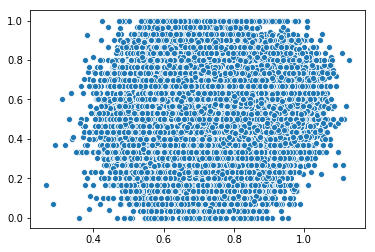

In [59]:
sns.scatterplot(pred_elmo__kap_dsc, sentences_kap_elmo_score)

In [60]:
r2_score(sentences_kap_elmo_score, pred_elmo__kap_dsc)

-1.6789691826939301

In [61]:
spearmanr(sentences_kap_elmo_score, pred_elmo__kap_dsc)

SpearmanrResult(correlation=0.10973609864859635, pvalue=1.0079657904429025e-180)

In [62]:
(round(rmse(sentences_kap_elmo_score, pred_elmo__kap_dsc), 3),
 round(1-rocauc(sentences_kap_elmo_score, pred_elmo__kap_dsc, .20, "low"), 3),
 round(rocauc(sentences_kap_elmo_score, pred_elmo__kap_dsc, .50, "high"), 3),
 round(rocauc(sentences_kap_elmo_score, pred_elmo__kap_dsc, .80, "high"), 3),
)

(0.284, 0.577, 0.556, 0.532)

## BERT + Att (longer sentence format)

### train the full DSCoVAR model

In [63]:
_tokenizer = create_tokenizer_from_hub_module()
_examples_dsc  = convert_text_to_examples(sent_dsc_bert[0],  sent_dsc_bert[1],  score_dsc_bws)
_input_ids_dsc,  _input_masks_dsc, _segment_ids_dsc, _targ_locs_dsc,  _scores_dsc  = convert_examples_to_features(_tokenizer, _examples_dsc, False, MAX_SEQ_LEN_BERT)

In [64]:
K.clear_session()
sess = tf.Session()

model_dsc_bert = build_model_bert(MAX_SEQ_LEN_BERT, finetune_emb=True, attention_layer=True, 
                              sep_cntx_targ=False, lr=3e-5)
initialize_vars(sess)

In [65]:
model_dsc_bert.fit([_input_ids_dsc,  _input_masks_dsc, _segment_ids_dsc, _targ_locs_dsc], _scores_dsc,
               epochs=5, batch_size=16, verbose=0,
               callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=False)])

In [66]:
model_dsc_bert.save_weights("./model_weights/finetune/bert/1emb/model_bert_notarg_wtattn_glv_full_i5_b16_lr3e-05_forkapelnerpred.tf")

### predict Kapelner et al. sentences

In [67]:
pred_bert__kap_dsc = np.reshape(model_dsc_bert.predict(
    [input_ids_kap_bert, input_masks_kap_bert, 
     segment_ids_kap_bert, targ_locs_kap_bert]), -1)

In [68]:
scores_kap_bert = np.reshape(scores_kap_bert, -1)

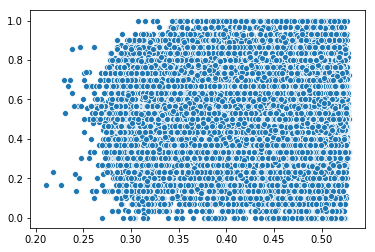

In [69]:
sns.scatterplot(pred_bert__kap_dsc, scores_kap_bert)

In [70]:
r2_score(scores_kap_bert, pred_bert__kap_dsc)

-0.46207202908930634

In [71]:
spearmanr(scores_kap_bert, pred_bert__kap_dsc)

SpearmanrResult(correlation=-0.004197006673427175, pvalue=0.27436339394487136)

In [72]:
(round(rmse(scores_kap_bert, pred_bert__kap_dsc), 3),
 round(1-rocauc(scores_kap_bert, pred_bert__kap_dsc, .20, "low"), 3),
 round(rocauc(scores_kap_bert, pred_bert__kap_dsc, .50, "high"), 3),
 round(rocauc(scores_kap_bert, pred_bert__kap_dsc, .80, "high"), 3),
)

(0.21, 0.502, 0.497, 0.492)